In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from A3C import A3C
from utils import discount
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
load = True
device = 0
np.random.seed(12345)
torch.random.manual_seed(12345)

## Maybe add in pseudo-random left/right later?

In [2]:
class lever():
    def __init__(self, FR_limit, PR_reward):
        super().__init__()
        self.mode = "PR"
        self.limits = {"PR":2, "FR":FR_limit}
        self.rewards = {"PR":PR_reward, "FR":1}
        self.progress = 0
    def pull(self, choice):
        modes = ["PR", "FR"]
        if modes[choice] == self.mode:
            self.progress += 1
        else:
            self.progress = 1
            self.mode = modes[choice]
        if self.progress > self.limits[modes[choice]]:
            print("error: progress shouldn't be greater than limit")
        if self.progress ==  self.limits[modes[choice]]:
            if modes[choice] == "PR":
                self.limits["PR"] += 1
            self.progress = 0
            return self.rewards[modes[choice]]
        return 0

agent = A3C().cuda(device)
optimizer = torch.optim.RMSprop(agent.parameters(), 0.0007)

In [3]:
# actions = [a0, a1, a2, ...., aT]
# value_preds = [V0, V1, V2, ...., VT]
# rewards = [r0, r1, r2, ..... , rT]
# value_target = []
def run_block(block_num, train = True, bv = 0.05, be = 0.05, discount_f = 0.75):
    num_presses = 2000 # perhaps this number needs to be changed
    FR_limit = [6, 12][np.random.choice(2)]
    PR_reward = [2, 5][np.random.choice(2)]
    experiment = lever(FR_limit, PR_reward)
    action = -1
    reward = 0.25 # this is an arbitrary number for the initial input
    lstm_state = None
    value_preds = []
    rewards = []
    actions = []
    policies = []
    for press_num in range(num_presses):
        action_probs, value_pred, lstm_state = agent(action, reward, lstm_state)
        action = np.random.choice([0, 1], p = action_probs.detach().cpu().numpy().flatten())
        reward = experiment.pull(action)
        policies.append(action_probs)
        value_preds.append(value_pred)
        actions.append(action)
        rewards.append(reward)
    value_targets = torch.Tensor(discount(rewards, discount_f)).cuda(device)
    value_preds = torch.Tensor(value_preds).cuda(device)
    policies = torch.cat(policies, dim = 0)
    actions = torch.Tensor(actions).long()
    advantage = (value_targets - value_preds).detach()
    if train:
        value_loss = torch.nn.MSELoss()(value_preds, value_targets)
        policy_loss = -torch.mean(torch.log(policies[torch.arange(policies.shape[0]), actions])*advantage)
        entropy_loss = torch.mean(torch.log(policies)*policies)*(20-block_num/1000)
        loss = policy_loss + value_loss*bv + entropy_loss*be
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    # collect data
    actions = actions.numpy()
    rewards = np.array(rewards)
    print('session block:', block_num, 'reward:', sum(rewards)/len(rewards))
    return actions, rewards, FR_limit, PR_reward

In [ ]:
if load and os.path.exists('models/PRvsFR.pth'):
    agent.load_state_dict(torch.load('models/PRvsFR.pth'))
else:
    for block_num in range(18000):
        run_block(block_num)
    torch.save(agent.state_dict(), "models/PRvsFR.pth")

session block: 0 reward: 0.0275
session block: 1 reward: 0.008
session block: 2 reward: 0.0225
session block: 3 reward: 0.009
session block: 4 reward: 0.0275
session block: 5 reward: 0.009
session block: 6 reward: 0.011
session block: 7 reward: 0.0285
session block: 8 reward: 0.0145
session block: 9 reward: 0.0165
session block: 10 reward: 0.009
session block: 11 reward: 0.0165
session block: 12 reward: 0.0175
session block: 13 reward: 0.0175
session block: 14 reward: 0.021
session block: 15 reward: 0.023
session block: 16 reward: 0.0175
session block: 17 reward: 0.0085
session block: 18 reward: 0.021
session block: 19 reward: 0.033
session block: 20 reward: 0.0305
session block: 21 reward: 0.026
session block: 22 reward: 0.021
session block: 23 reward: 0.0095
session block: 24 reward: 0.0195
session block: 25 reward: 0.023
session block: 26 reward: 0.03
session block: 27 reward: 0.036
session block: 28 reward: 0.011
session block: 29 reward: 0.026
session block: 30 reward: 0.0255
sess

session block: 249 reward: 0.021
session block: 250 reward: 0.0275
session block: 251 reward: 0.012
session block: 252 reward: 0.0375
session block: 253 reward: 0.043
session block: 254 reward: 0.03
session block: 255 reward: 0.0325
session block: 256 reward: 0.012
session block: 257 reward: 0.043
session block: 258 reward: 0.0445
session block: 259 reward: 0.0215
session block: 260 reward: 0.0285
session block: 261 reward: 0.049
session block: 262 reward: 0.0455
session block: 263 reward: 0.025
session block: 264 reward: 0.0335
session block: 265 reward: 0.0415
session block: 266 reward: 0.03
session block: 267 reward: 0.0375
session block: 268 reward: 0.035
session block: 269 reward: 0.0355
session block: 270 reward: 0.03
session block: 271 reward: 0.012
session block: 272 reward: 0.0185
session block: 273 reward: 0.011
session block: 274 reward: 0.0275
session block: 275 reward: 0.0245
session block: 276 reward: 0.025
session block: 277 reward: 0.024
session block: 278 reward: 0.023

session block: 495 reward: 0.0255
session block: 496 reward: 0.009
session block: 497 reward: 0.037
session block: 498 reward: 0.015
session block: 499 reward: 0.0125
session block: 500 reward: 0.0275
session block: 501 reward: 0.023
session block: 502 reward: 0.012
session block: 503 reward: 0.0275
session block: 504 reward: 0.04
session block: 505 reward: 0.0375
session block: 506 reward: 0.0405
session block: 507 reward: 0.05
session block: 508 reward: 0.0255
session block: 509 reward: 0.0325
session block: 510 reward: 0.0245
session block: 511 reward: 0.024
session block: 512 reward: 0.0385
session block: 513 reward: 0.0145
session block: 514 reward: 0.0405
session block: 515 reward: 0.035
session block: 516 reward: 0.028
session block: 517 reward: 0.014
session block: 518 reward: 0.0325
session block: 519 reward: 0.024
session block: 520 reward: 0.046
session block: 521 reward: 0.035
session block: 522 reward: 0.013
session block: 523 reward: 0.0385
session block: 524 reward: 0.04

session block: 741 reward: 0.015
session block: 742 reward: 0.0435
session block: 743 reward: 0.0405
session block: 744 reward: 0.0495
session block: 745 reward: 0.033
session block: 746 reward: 0.0515
session block: 747 reward: 0.0355
session block: 748 reward: 0.0265
session block: 749 reward: 0.03
session block: 750 reward: 0.014
session block: 751 reward: 0.0315
session block: 752 reward: 0.025
session block: 753 reward: 0.052
session block: 754 reward: 0.015
session block: 755 reward: 0.0425
session block: 756 reward: 0.052
session block: 757 reward: 0.0605
session block: 758 reward: 0.016
session block: 759 reward: 0.0245
session block: 760 reward: 0.023
session block: 761 reward: 0.0305
session block: 762 reward: 0.0385
session block: 763 reward: 0.025
session block: 764 reward: 0.033
session block: 765 reward: 0.0155
session block: 766 reward: 0.0155
session block: 767 reward: 0.0515
session block: 768 reward: 0.0325
session block: 769 reward: 0.027
session block: 770 reward: 0

session block: 987 reward: 0.056
session block: 988 reward: 0.06
session block: 989 reward: 0.035
session block: 990 reward: 0.0225
session block: 991 reward: 0.012
session block: 992 reward: 0.014
session block: 993 reward: 0.03
session block: 994 reward: 0.026
session block: 995 reward: 0.027
session block: 996 reward: 0.0425
session block: 997 reward: 0.0555
session block: 998 reward: 0.043
session block: 999 reward: 0.058
session block: 1000 reward: 0.027
session block: 1001 reward: 0.0545
session block: 1002 reward: 0.03
session block: 1003 reward: 0.0235
session block: 1004 reward: 0.024
session block: 1005 reward: 0.035
session block: 1006 reward: 0.0485
session block: 1007 reward: 0.013
session block: 1008 reward: 0.0405
session block: 1009 reward: 0.016
session block: 1010 reward: 0.05
session block: 1011 reward: 0.0185
session block: 1012 reward: 0.038
session block: 1013 reward: 0.015
session block: 1014 reward: 0.02
session block: 1015 reward: 0.015
session block: 1016 rewa

session block: 1226 reward: 0.0565
session block: 1227 reward: 0.014
session block: 1228 reward: 0.025
session block: 1229 reward: 0.0205
session block: 1230 reward: 0.051
session block: 1231 reward: 0.0205
session block: 1232 reward: 0.0125
session block: 1233 reward: 0.0165
session block: 1234 reward: 0.024
session block: 1235 reward: 0.0425
session block: 1236 reward: 0.0315
session block: 1237 reward: 0.026
session block: 1238 reward: 0.023
session block: 1239 reward: 0.049
session block: 1240 reward: 0.053
session block: 1241 reward: 0.033
session block: 1242 reward: 0.026
session block: 1243 reward: 0.024
session block: 1244 reward: 0.036
session block: 1245 reward: 0.053
session block: 1246 reward: 0.0125
session block: 1247 reward: 0.0545
session block: 1248 reward: 0.054
session block: 1249 reward: 0.0365
session block: 1250 reward: 0.028
session block: 1251 reward: 0.0505
session block: 1252 reward: 0.059
session block: 1253 reward: 0.015
session block: 1254 reward: 0.0195
se

session block: 1465 reward: 0.0485
session block: 1466 reward: 0.054
session block: 1467 reward: 0.0275
session block: 1468 reward: 0.042
session block: 1469 reward: 0.0335
session block: 1470 reward: 0.028
session block: 1471 reward: 0.052
session block: 1472 reward: 0.04
session block: 1473 reward: 0.055
session block: 1474 reward: 0.0425
session block: 1475 reward: 0.0525
session block: 1476 reward: 0.0275
session block: 1477 reward: 0.0115
session block: 1478 reward: 0.012
session block: 1479 reward: 0.024
session block: 1480 reward: 0.014
session block: 1481 reward: 0.035
session block: 1482 reward: 0.0235
session block: 1483 reward: 0.0375
session block: 1484 reward: 0.0245
session block: 1485 reward: 0.0265
session block: 1486 reward: 0.042
session block: 1487 reward: 0.0175
session block: 1488 reward: 0.049
session block: 1489 reward: 0.0575
session block: 1490 reward: 0.031
session block: 1491 reward: 0.04
session block: 1492 reward: 0.0295
session block: 1493 reward: 0.012
se

session block: 1704 reward: 0.0455
session block: 1705 reward: 0.0245
session block: 1706 reward: 0.0395
session block: 1707 reward: 0.0405
session block: 1708 reward: 0.016
session block: 1709 reward: 0.0235
session block: 1710 reward: 0.0145
session block: 1711 reward: 0.012
session block: 1712 reward: 0.03
session block: 1713 reward: 0.013
session block: 1714 reward: 0.02
session block: 1715 reward: 0.01
session block: 1716 reward: 0.035
session block: 1717 reward: 0.0165
session block: 1718 reward: 0.017
session block: 1719 reward: 0.0105
session block: 1720 reward: 0.01
session block: 1721 reward: 0.0225
session block: 1722 reward: 0.0305
session block: 1723 reward: 0.0325
session block: 1724 reward: 0.0455
session block: 1725 reward: 0.06
session block: 1726 reward: 0.023
session block: 1727 reward: 0.03
session block: 1728 reward: 0.04
session block: 1729 reward: 0.055
session block: 1730 reward: 0.0505
session block: 1731 reward: 0.048
session block: 1732 reward: 0.059
session 

session block: 1943 reward: 0.025
session block: 1944 reward: 0.0265
session block: 1945 reward: 0.049
session block: 1946 reward: 0.025
session block: 1947 reward: 0.035
session block: 1948 reward: 0.066
session block: 1949 reward: 0.0405
session block: 1950 reward: 0.0555
session block: 1951 reward: 0.0505
session block: 1952 reward: 0.014
session block: 1953 reward: 0.0405
session block: 1954 reward: 0.029
session block: 1955 reward: 0.009
session block: 1956 reward: 0.0095
session block: 1957 reward: 0.012
session block: 1958 reward: 0.048
session block: 1959 reward: 0.0515
session block: 1960 reward: 0.035
session block: 1961 reward: 0.0245
session block: 1962 reward: 0.0495
session block: 1963 reward: 0.0465
session block: 1964 reward: 0.0515
session block: 1965 reward: 0.0425
session block: 1966 reward: 0.046
session block: 1967 reward: 0.048
session block: 1968 reward: 0.064
session block: 1969 reward: 0.0605
session block: 1970 reward: 0.0125
session block: 1971 reward: 0.063


session block: 2182 reward: 0.014
session block: 2183 reward: 0.0105
session block: 2184 reward: 0.04
session block: 2185 reward: 0.023
session block: 2186 reward: 0.0155
session block: 2187 reward: 0.0425
session block: 2188 reward: 0.0165
session block: 2189 reward: 0.021
session block: 2190 reward: 0.047
session block: 2191 reward: 0.0535
session block: 2192 reward: 0.017
session block: 2193 reward: 0.0605
session block: 2194 reward: 0.021
session block: 2195 reward: 0.043
session block: 2196 reward: 0.0245
session block: 2197 reward: 0.0565
session block: 2198 reward: 0.047
session block: 2199 reward: 0.0405
session block: 2200 reward: 0.022
session block: 2201 reward: 0.012
session block: 2202 reward: 0.027
session block: 2203 reward: 0.0475
session block: 2204 reward: 0.0605
session block: 2205 reward: 0.0135
session block: 2206 reward: 0.015
session block: 2207 reward: 0.0225
session block: 2208 reward: 0.054
session block: 2209 reward: 0.0315
session block: 2210 reward: 0.0105


session block: 2420 reward: 0.055
session block: 2421 reward: 0.052
session block: 2422 reward: 0.058
session block: 2423 reward: 0.0735
session block: 2424 reward: 0.027
session block: 2425 reward: 0.036
session block: 2426 reward: 0.0295
session block: 2427 reward: 0.0315
session block: 2428 reward: 0.032
session block: 2429 reward: 0.048
session block: 2430 reward: 0.0255
session block: 2431 reward: 0.0355
session block: 2432 reward: 0.0275
session block: 2433 reward: 0.0135
session block: 2434 reward: 0.0545
session block: 2435 reward: 0.0665
session block: 2436 reward: 0.046
session block: 2437 reward: 0.017
session block: 2438 reward: 0.05
session block: 2439 reward: 0.0315
session block: 2440 reward: 0.035
session block: 2441 reward: 0.0575
session block: 2442 reward: 0.0375
session block: 2443 reward: 0.012
session block: 2444 reward: 0.0245
session block: 2445 reward: 0.0425
session block: 2446 reward: 0.0315
session block: 2447 reward: 0.044
session block: 2448 reward: 0.0345

session block: 2659 reward: 0.0155
session block: 2660 reward: 0.0525
session block: 2661 reward: 0.0195
session block: 2662 reward: 0.0295
session block: 2663 reward: 0.049
session block: 2664 reward: 0.0605
session block: 2665 reward: 0.0205
session block: 2666 reward: 0.039
session block: 2667 reward: 0.055
session block: 2668 reward: 0.073
session block: 2669 reward: 0.014
session block: 2670 reward: 0.0455
session block: 2671 reward: 0.0705
session block: 2672 reward: 0.013
session block: 2673 reward: 0.0265
session block: 2674 reward: 0.0115
session block: 2675 reward: 0.03
session block: 2676 reward: 0.0215
session block: 2677 reward: 0.0585
session block: 2678 reward: 0.052
session block: 2679 reward: 0.0465
session block: 2680 reward: 0.0665
session block: 2681 reward: 0.041
session block: 2682 reward: 0.0565
session block: 2683 reward: 0.0365
session block: 2684 reward: 0.0625
session block: 2685 reward: 0.0475
session block: 2686 reward: 0.0175
session block: 2687 reward: 0.

session block: 2897 reward: 0.017
session block: 2898 reward: 0.06
session block: 2899 reward: 0.053
session block: 2900 reward: 0.0325
session block: 2901 reward: 0.014
session block: 2902 reward: 0.0405
session block: 2903 reward: 0.039
session block: 2904 reward: 0.0535
session block: 2905 reward: 0.03
session block: 2906 reward: 0.026
session block: 2907 reward: 0.055
session block: 2908 reward: 0.013
session block: 2909 reward: 0.026
session block: 2910 reward: 0.034
session block: 2911 reward: 0.0425
session block: 2912 reward: 0.046
session block: 2913 reward: 0.0265
session block: 2914 reward: 0.0275
session block: 2915 reward: 0.024
session block: 2916 reward: 0.038
session block: 2917 reward: 0.0565
session block: 2918 reward: 0.0425
session block: 2919 reward: 0.059
session block: 2920 reward: 0.017
session block: 2921 reward: 0.032
session block: 2922 reward: 0.023
session block: 2923 reward: 0.016
session block: 2924 reward: 0.013
session block: 2925 reward: 0.0565
session

session block: 3136 reward: 0.0495
session block: 3137 reward: 0.038
session block: 3138 reward: 0.0505
session block: 3139 reward: 0.019
session block: 3140 reward: 0.0175
session block: 3141 reward: 0.0125
session block: 3142 reward: 0.019
session block: 3143 reward: 0.0425
session block: 3144 reward: 0.029
session block: 3145 reward: 0.0435
session block: 3146 reward: 0.05
session block: 3147 reward: 0.0605
session block: 3148 reward: 0.041
session block: 3149 reward: 0.0675
session block: 3150 reward: 0.0285
session block: 3151 reward: 0.0135
session block: 3152 reward: 0.055
session block: 3153 reward: 0.0545
session block: 3154 reward: 0.0165
session block: 3155 reward: 0.0625
session block: 3156 reward: 0.0385
session block: 3157 reward: 0.017
session block: 3158 reward: 0.0125
session block: 3159 reward: 0.0515
session block: 3160 reward: 0.021
session block: 3161 reward: 0.0545
session block: 3162 reward: 0.028
session block: 3163 reward: 0.0405
session block: 3164 reward: 0.0

session block: 3374 reward: 0.048
session block: 3375 reward: 0.0515
session block: 3376 reward: 0.046
session block: 3377 reward: 0.0345
session block: 3378 reward: 0.0145
session block: 3379 reward: 0.0475
session block: 3380 reward: 0.034
session block: 3381 reward: 0.0205
session block: 3382 reward: 0.0175
session block: 3383 reward: 0.0365
session block: 3384 reward: 0.0535
session block: 3385 reward: 0.069
session block: 3386 reward: 0.014
session block: 3387 reward: 0.0305
session block: 3388 reward: 0.0405
session block: 3389 reward: 0.04
session block: 3390 reward: 0.0205
session block: 3391 reward: 0.0235
session block: 3392 reward: 0.037
session block: 3393 reward: 0.028
session block: 3394 reward: 0.0495
session block: 3395 reward: 0.02
session block: 3396 reward: 0.0185
session block: 3397 reward: 0.062
session block: 3398 reward: 0.0655
session block: 3399 reward: 0.013
session block: 3400 reward: 0.047
session block: 3401 reward: 0.023
session block: 3402 reward: 0.0245


session block: 3612 reward: 0.055
session block: 3613 reward: 0.024
session block: 3614 reward: 0.0275
session block: 3615 reward: 0.032
session block: 3616 reward: 0.055
session block: 3617 reward: 0.0545
session block: 3618 reward: 0.039
session block: 3619 reward: 0.0565
session block: 3620 reward: 0.031
session block: 3621 reward: 0.054
session block: 3622 reward: 0.018
session block: 3623 reward: 0.0145
session block: 3624 reward: 0.019
session block: 3625 reward: 0.043
session block: 3626 reward: 0.0265
session block: 3627 reward: 0.023
session block: 3628 reward: 0.0505
session block: 3629 reward: 0.036
session block: 3630 reward: 0.0395
session block: 3631 reward: 0.0415
session block: 3632 reward: 0.0435
session block: 3633 reward: 0.0395
session block: 3634 reward: 0.017
session block: 3635 reward: 0.0115
session block: 3636 reward: 0.02
session block: 3637 reward: 0.0425
session block: 3638 reward: 0.068
session block: 3639 reward: 0.036
session block: 3640 reward: 0.0755
se

session block: 3850 reward: 0.0325
session block: 3851 reward: 0.038
session block: 3852 reward: 0.081
session block: 3853 reward: 0.047
session block: 3854 reward: 0.0315
session block: 3855 reward: 0.0475
session block: 3856 reward: 0.0325
session block: 3857 reward: 0.0355
session block: 3858 reward: 0.016
session block: 3859 reward: 0.0295
session block: 3860 reward: 0.0435
session block: 3861 reward: 0.0355
session block: 3862 reward: 0.0285
session block: 3863 reward: 0.056
session block: 3864 reward: 0.04
session block: 3865 reward: 0.021
session block: 3866 reward: 0.0365
session block: 3867 reward: 0.041
session block: 3868 reward: 0.066
session block: 3869 reward: 0.0355
session block: 3870 reward: 0.055
session block: 3871 reward: 0.0495
session block: 3872 reward: 0.0435
session block: 3873 reward: 0.031
session block: 3874 reward: 0.0325
session block: 3875 reward: 0.056
session block: 3876 reward: 0.0655
session block: 3877 reward: 0.0595
session block: 3878 reward: 0.044

session block: 4088 reward: 0.0385
session block: 4089 reward: 0.0355
session block: 4090 reward: 0.0445
session block: 4091 reward: 0.015
session block: 4092 reward: 0.0285
session block: 4093 reward: 0.035
session block: 4094 reward: 0.0205
session block: 4095 reward: 0.0305
session block: 4096 reward: 0.013
session block: 4097 reward: 0.031
session block: 4098 reward: 0.0285
session block: 4099 reward: 0.051
session block: 4100 reward: 0.0385
session block: 4101 reward: 0.037
session block: 4102 reward: 0.0365
session block: 4103 reward: 0.0615
session block: 4104 reward: 0.0165
session block: 4105 reward: 0.062
session block: 4106 reward: 0.0305
session block: 4107 reward: 0.0205
session block: 4108 reward: 0.03
session block: 4109 reward: 0.0365
session block: 4110 reward: 0.0465
session block: 4111 reward: 0.051
session block: 4112 reward: 0.0605
session block: 4113 reward: 0.0615
session block: 4114 reward: 0.016
session block: 4115 reward: 0.021
session block: 4116 reward: 0.01

session block: 4326 reward: 0.051
session block: 4327 reward: 0.06
session block: 4328 reward: 0.0535
session block: 4329 reward: 0.0305
session block: 4330 reward: 0.0305
session block: 4331 reward: 0.0315
session block: 4332 reward: 0.0695
session block: 4333 reward: 0.017
session block: 4334 reward: 0.0295
session block: 4335 reward: 0.042
session block: 4336 reward: 0.051
session block: 4337 reward: 0.0365
session block: 4338 reward: 0.055
session block: 4339 reward: 0.017
session block: 4340 reward: 0.039
session block: 4341 reward: 0.0205
session block: 4342 reward: 0.0125
session block: 4343 reward: 0.025
session block: 4344 reward: 0.04
session block: 4345 reward: 0.048
session block: 4346 reward: 0.02
session block: 4347 reward: 0.0395
session block: 4348 reward: 0.0565
session block: 4349 reward: 0.058
session block: 4350 reward: 0.0425
session block: 4351 reward: 0.053
session block: 4352 reward: 0.0305
session block: 4353 reward: 0.0405
session block: 4354 reward: 0.031
ses

session block: 4565 reward: 0.059
session block: 4566 reward: 0.0295
session block: 4567 reward: 0.0295
session block: 4568 reward: 0.0135
session block: 4569 reward: 0.0355
session block: 4570 reward: 0.049
session block: 4571 reward: 0.0335
session block: 4572 reward: 0.0115
session block: 4573 reward: 0.0165
session block: 4574 reward: 0.0565
session block: 4575 reward: 0.015
session block: 4576 reward: 0.038
session block: 4577 reward: 0.0215
session block: 4578 reward: 0.0525
session block: 4579 reward: 0.0145
session block: 4580 reward: 0.0525
session block: 4581 reward: 0.063
session block: 4582 reward: 0.0365
session block: 4583 reward: 0.0515
session block: 4584 reward: 0.031
session block: 4585 reward: 0.0105
session block: 4586 reward: 0.024
session block: 4587 reward: 0.0115
session block: 4588 reward: 0.0145
session block: 4589 reward: 0.038
session block: 4590 reward: 0.02
session block: 4591 reward: 0.047
session block: 4592 reward: 0.0165
session block: 4593 reward: 0.0

session block: 4804 reward: 0.06
session block: 4805 reward: 0.012
session block: 4806 reward: 0.0415
session block: 4807 reward: 0.0475
session block: 4808 reward: 0.0305
session block: 4809 reward: 0.0115
session block: 4810 reward: 0.053
session block: 4811 reward: 0.0495
session block: 4812 reward: 0.043
session block: 4813 reward: 0.0435
session block: 4814 reward: 0.0595
session block: 4815 reward: 0.0615
session block: 4816 reward: 0.0415
session block: 4817 reward: 0.055
session block: 4818 reward: 0.059
session block: 4819 reward: 0.045
session block: 4820 reward: 0.018
session block: 4821 reward: 0.012
session block: 4822 reward: 0.017
session block: 4823 reward: 0.033
session block: 4824 reward: 0.0385
session block: 4825 reward: 0.016
session block: 4826 reward: 0.0615
session block: 4827 reward: 0.0385
session block: 4828 reward: 0.046
session block: 4829 reward: 0.0315
session block: 4830 reward: 0.05
session block: 4831 reward: 0.0405
session block: 4832 reward: 0.017
se

session block: 5042 reward: 0.0385
session block: 5043 reward: 0.019
session block: 5044 reward: 0.0165
session block: 5045 reward: 0.036
session block: 5046 reward: 0.04
session block: 5047 reward: 0.037
session block: 5048 reward: 0.046
session block: 5049 reward: 0.0205
session block: 5050 reward: 0.048
session block: 5051 reward: 0.0195
session block: 5052 reward: 0.0535
session block: 5053 reward: 0.049
session block: 5054 reward: 0.0355
session block: 5055 reward: 0.013
session block: 5056 reward: 0.0205
session block: 5057 reward: 0.059
session block: 5058 reward: 0.0495
session block: 5059 reward: 0.018
session block: 5060 reward: 0.0485
session block: 5061 reward: 0.0455
session block: 5062 reward: 0.0725
session block: 5063 reward: 0.0355
session block: 5064 reward: 0.035
session block: 5065 reward: 0.0285
session block: 5066 reward: 0.014
session block: 5067 reward: 0.0565
session block: 5068 reward: 0.052
session block: 5069 reward: 0.037
session block: 5070 reward: 0.054
s

session block: 5281 reward: 0.0525
session block: 5282 reward: 0.0265
session block: 5283 reward: 0.0575
session block: 5284 reward: 0.0325
session block: 5285 reward: 0.047
session block: 5286 reward: 0.034
session block: 5287 reward: 0.037
session block: 5288 reward: 0.01
session block: 5289 reward: 0.037
session block: 5290 reward: 0.045
session block: 5291 reward: 0.0625
session block: 5292 reward: 0.044
session block: 5293 reward: 0.068
session block: 5294 reward: 0.034
session block: 5295 reward: 0.06
session block: 5296 reward: 0.0415
session block: 5297 reward: 0.032
session block: 5298 reward: 0.0175
session block: 5299 reward: 0.0425
session block: 5300 reward: 0.0345
session block: 5301 reward: 0.036
session block: 5302 reward: 0.0645
session block: 5303 reward: 0.04
session block: 5304 reward: 0.037
session block: 5305 reward: 0.039
session block: 5306 reward: 0.0385
session block: 5307 reward: 0.0375
session block: 5308 reward: 0.0425
session block: 5309 reward: 0.039
sess

session block: 5519 reward: 0.059
session block: 5520 reward: 0.054
session block: 5521 reward: 0.0385
session block: 5522 reward: 0.047
session block: 5523 reward: 0.044
session block: 5524 reward: 0.052
session block: 5525 reward: 0.015
session block: 5526 reward: 0.018
session block: 5527 reward: 0.019
session block: 5528 reward: 0.0585
session block: 5529 reward: 0.0625
session block: 5530 reward: 0.0165
session block: 5531 reward: 0.07
session block: 5532 reward: 0.0625
session block: 5533 reward: 0.059
session block: 5534 reward: 0.0655
session block: 5535 reward: 0.041
session block: 5536 reward: 0.037
session block: 5537 reward: 0.0655
session block: 5538 reward: 0.038
session block: 5539 reward: 0.045
session block: 5540 reward: 0.013
session block: 5541 reward: 0.0295
session block: 5542 reward: 0.014
session block: 5543 reward: 0.0135
session block: 5544 reward: 0.0255
session block: 5545 reward: 0.013
session block: 5546 reward: 0.0335
session block: 5547 reward: 0.046
sess

session block: 5758 reward: 0.0165
session block: 5759 reward: 0.0385
session block: 5760 reward: 0.0435
session block: 5761 reward: 0.0615
session block: 5762 reward: 0.033
session block: 5763 reward: 0.042
session block: 5764 reward: 0.0445
session block: 5765 reward: 0.0595
session block: 5766 reward: 0.042
session block: 5767 reward: 0.039
session block: 5768 reward: 0.0575
session block: 5769 reward: 0.063
session block: 5770 reward: 0.063
session block: 5771 reward: 0.0365
session block: 5772 reward: 0.045
session block: 5773 reward: 0.0205
session block: 5774 reward: 0.0585
session block: 5775 reward: 0.066
session block: 5776 reward: 0.0375
session block: 5777 reward: 0.041
session block: 5778 reward: 0.0365
session block: 5779 reward: 0.0195
session block: 5780 reward: 0.018
session block: 5781 reward: 0.031
session block: 5782 reward: 0.042
session block: 5783 reward: 0.056
session block: 5784 reward: 0.0165
session block: 5785 reward: 0.048
session block: 5786 reward: 0.0285

session block: 5996 reward: 0.037
session block: 5997 reward: 0.0185
session block: 5998 reward: 0.0225
session block: 5999 reward: 0.0575
session block: 6000 reward: 0.0585
session block: 6001 reward: 0.033
session block: 6002 reward: 0.0715
session block: 6003 reward: 0.0615
session block: 6004 reward: 0.016
session block: 6005 reward: 0.018
session block: 6006 reward: 0.0405
session block: 6007 reward: 0.0645
session block: 6008 reward: 0.033
session block: 6009 reward: 0.0485
session block: 6010 reward: 0.0465
session block: 6011 reward: 0.015
session block: 6012 reward: 0.018
session block: 6013 reward: 0.0165
session block: 6014 reward: 0.055
session block: 6015 reward: 0.0315
session block: 6016 reward: 0.066
session block: 6017 reward: 0.0125
session block: 6018 reward: 0.07
session block: 6019 reward: 0.039
session block: 6020 reward: 0.0305
session block: 6021 reward: 0.025
session block: 6022 reward: 0.0195
session block: 6023 reward: 0.0345
session block: 6024 reward: 0.032

session block: 6234 reward: 0.0185
session block: 6235 reward: 0.06
session block: 6236 reward: 0.0195
session block: 6237 reward: 0.052
session block: 6238 reward: 0.0165
session block: 6239 reward: 0.0155
session block: 6240 reward: 0.0665
session block: 6241 reward: 0.0615
session block: 6242 reward: 0.062
session block: 6243 reward: 0.0685
session block: 6244 reward: 0.038
session block: 6245 reward: 0.064
session block: 6246 reward: 0.0495
session block: 6247 reward: 0.0465
session block: 6248 reward: 0.0435
session block: 6249 reward: 0.015
session block: 6250 reward: 0.0435
session block: 6251 reward: 0.0375
session block: 6252 reward: 0.0635
session block: 6253 reward: 0.048
session block: 6254 reward: 0.015
session block: 6255 reward: 0.037
session block: 6256 reward: 0.03
session block: 6257 reward: 0.0605
session block: 6258 reward: 0.043
session block: 6259 reward: 0.0555
session block: 6260 reward: 0.0515
session block: 6261 reward: 0.0375
session block: 6262 reward: 0.016

session block: 6472 reward: 0.0455
session block: 6473 reward: 0.027
session block: 6474 reward: 0.0495
session block: 6475 reward: 0.02
session block: 6476 reward: 0.0445
session block: 6477 reward: 0.055
session block: 6478 reward: 0.0225
session block: 6479 reward: 0.016
session block: 6480 reward: 0.046
session block: 6481 reward: 0.0345
session block: 6482 reward: 0.0285
session block: 6483 reward: 0.0325
session block: 6484 reward: 0.044
session block: 6485 reward: 0.019
session block: 6486 reward: 0.05
session block: 6487 reward: 0.019
session block: 6488 reward: 0.0365
session block: 6489 reward: 0.0155
session block: 6490 reward: 0.0175
session block: 6491 reward: 0.0205
session block: 6492 reward: 0.0295
session block: 6493 reward: 0.0575
session block: 6494 reward: 0.0645
session block: 6495 reward: 0.0145
session block: 6496 reward: 0.069
session block: 6497 reward: 0.017
session block: 6498 reward: 0.0165
session block: 6499 reward: 0.0405
session block: 6500 reward: 0.073

session block: 6710 reward: 0.072
session block: 6711 reward: 0.0385
session block: 6712 reward: 0.066
session block: 6713 reward: 0.036
session block: 6714 reward: 0.0335
session block: 6715 reward: 0.015
session block: 6716 reward: 0.0385
session block: 6717 reward: 0.048
session block: 6718 reward: 0.0495
session block: 6719 reward: 0.0155
session block: 6720 reward: 0.038
session block: 6721 reward: 0.043
session block: 6722 reward: 0.0365
session block: 6723 reward: 0.0615
session block: 6724 reward: 0.016
session block: 6725 reward: 0.0755
session block: 6726 reward: 0.0435
session block: 6727 reward: 0.0145
session block: 6728 reward: 0.0715
session block: 6729 reward: 0.0165
session block: 6730 reward: 0.068
session block: 6731 reward: 0.018
session block: 6732 reward: 0.0455
session block: 6733 reward: 0.044
session block: 6734 reward: 0.0395
session block: 6735 reward: 0.0375
session block: 6736 reward: 0.069
session block: 6737 reward: 0.0485
session block: 6738 reward: 0.04

session block: 6948 reward: 0.039
session block: 6949 reward: 0.042
session block: 6950 reward: 0.0475
session block: 6951 reward: 0.0175
session block: 6952 reward: 0.0375
session block: 6953 reward: 0.044
session block: 6954 reward: 0.0805
session block: 6955 reward: 0.049
session block: 6956 reward: 0.0155
session block: 6957 reward: 0.041
session block: 6958 reward: 0.0435
session block: 6959 reward: 0.0155
session block: 6960 reward: 0.0385
session block: 6961 reward: 0.038
session block: 6962 reward: 0.015
session block: 6963 reward: 0.018
session block: 6964 reward: 0.0315
session block: 6965 reward: 0.0175
session block: 6966 reward: 0.0305
session block: 6967 reward: 0.059
session block: 6968 reward: 0.0685
session block: 6969 reward: 0.052
session block: 6970 reward: 0.0405
session block: 6971 reward: 0.0475
session block: 6972 reward: 0.0655
session block: 6973 reward: 0.0415
session block: 6974 reward: 0.068
session block: 6975 reward: 0.0195
session block: 6976 reward: 0.0

session block: 7186 reward: 0.066
session block: 7187 reward: 0.0465
session block: 7188 reward: 0.0575
session block: 7189 reward: 0.0415
session block: 7190 reward: 0.077
session block: 7191 reward: 0.042
session block: 7192 reward: 0.0475
session block: 7193 reward: 0.052
session block: 7194 reward: 0.04
session block: 7195 reward: 0.0445
session block: 7196 reward: 0.07
session block: 7197 reward: 0.051
session block: 7198 reward: 0.0735
session block: 7199 reward: 0.0435
session block: 7200 reward: 0.048
session block: 7201 reward: 0.045
session block: 7202 reward: 0.0485
session block: 7203 reward: 0.0525
session block: 7204 reward: 0.075
session block: 7205 reward: 0.046
session block: 7206 reward: 0.0235
session block: 7207 reward: 0.0515
session block: 7208 reward: 0.0615
session block: 7209 reward: 0.075
session block: 7210 reward: 0.0215
session block: 7211 reward: 0.0175
session block: 7212 reward: 0.0425
session block: 7213 reward: 0.0555
session block: 7214 reward: 0.015


session block: 7424 reward: 0.067
session block: 7425 reward: 0.078
session block: 7426 reward: 0.086
session block: 7427 reward: 0.0585
session block: 7428 reward: 0.0165
session block: 7429 reward: 0.0295
session block: 7430 reward: 0.0575
session block: 7431 reward: 0.042
session block: 7432 reward: 0.0625
session block: 7433 reward: 0.0345
session block: 7434 reward: 0.012
session block: 7435 reward: 0.016
session block: 7436 reward: 0.022
session block: 7437 reward: 0.0305
session block: 7438 reward: 0.065
session block: 7439 reward: 0.0815
session block: 7440 reward: 0.0455
session block: 7441 reward: 0.076
session block: 7442 reward: 0.0755
session block: 7443 reward: 0.054
session block: 7444 reward: 0.0415
session block: 7445 reward: 0.045
session block: 7446 reward: 0.053
session block: 7447 reward: 0.041
session block: 7448 reward: 0.076
session block: 7449 reward: 0.0455
session block: 7450 reward: 0.0205
session block: 7451 reward: 0.077
session block: 7452 reward: 0.0195


session block: 7662 reward: 0.022
session block: 7663 reward: 0.0515
session block: 7664 reward: 0.078
session block: 7665 reward: 0.09
session block: 7666 reward: 0.072
session block: 7667 reward: 0.02
session block: 7668 reward: 0.076
session block: 7669 reward: 0.06
session block: 7670 reward: 0.017
session block: 7671 reward: 0.077
session block: 7672 reward: 0.019
session block: 7673 reward: 0.0445
session block: 7674 reward: 0.046
session block: 7675 reward: 0.0115
session block: 7676 reward: 0.019
session block: 7677 reward: 0.016
session block: 7678 reward: 0.014
session block: 7679 reward: 0.016
session block: 7680 reward: 0.014
session block: 7681 reward: 0.079
session block: 7682 reward: 0.0195
session block: 7683 reward: 0.0745
session block: 7684 reward: 0.066
session block: 7685 reward: 0.085
session block: 7686 reward: 0.0595
session block: 7687 reward: 0.0425
session block: 7688 reward: 0.049
session block: 7689 reward: 0.0675
session block: 7690 reward: 0.08
session bl

session block: 7901 reward: 0.0165
session block: 7902 reward: 0.053
session block: 7903 reward: 0.081
session block: 7904 reward: 0.0145
session block: 7905 reward: 0.064
session block: 7906 reward: 0.053
session block: 7907 reward: 0.06
session block: 7908 reward: 0.0465
session block: 7909 reward: 0.0465
session block: 7910 reward: 0.0675
session block: 7911 reward: 0.039
session block: 7912 reward: 0.055
session block: 7913 reward: 0.0465
session block: 7914 reward: 0.071
session block: 7915 reward: 0.043
session block: 7916 reward: 0.0525
session block: 7917 reward: 0.038
session block: 7918 reward: 0.0655
session block: 7919 reward: 0.019
session block: 7920 reward: 0.0345
session block: 7921 reward: 0.041
session block: 7922 reward: 0.0765
session block: 7923 reward: 0.0685
session block: 7924 reward: 0.0785
session block: 7925 reward: 0.046
session block: 7926 reward: 0.046
session block: 7927 reward: 0.019
session block: 7928 reward: 0.0415
session block: 7929 reward: 0.038
se

session block: 8139 reward: 0.0985
session block: 8140 reward: 0.043
session block: 8141 reward: 0.0885
session block: 8142 reward: 0.0555
session block: 8143 reward: 0.1005
session block: 8144 reward: 0.076
session block: 8145 reward: 0.0585
session block: 8146 reward: 0.077
session block: 8147 reward: 0.0695
session block: 8148 reward: 0.0215
session block: 8149 reward: 0.0695
session block: 8150 reward: 0.1085
session block: 8151 reward: 0.092
session block: 8152 reward: 0.049
session block: 8153 reward: 0.0725
session block: 8154 reward: 0.017
session block: 8155 reward: 0.1085
session block: 8156 reward: 0.0785
session block: 8157 reward: 0.0375
session block: 8158 reward: 0.0655
session block: 8159 reward: 0.074
session block: 8160 reward: 0.0745
session block: 8161 reward: 0.0755
session block: 8162 reward: 0.0665
session block: 8163 reward: 0.021
session block: 8164 reward: 0.108
session block: 8165 reward: 0.0995
session block: 8166 reward: 0.067
session block: 8167 reward: 0.

session block: 8377 reward: 0.083
session block: 8378 reward: 0.025
session block: 8379 reward: 0.049
session block: 8380 reward: 0.0275
session block: 8381 reward: 0.046
session block: 8382 reward: 0.082
session block: 8383 reward: 0.058
session block: 8384 reward: 0.0145
session block: 8385 reward: 0.0485
session block: 8386 reward: 0.0865
session block: 8387 reward: 0.025
session block: 8388 reward: 0.0465
session block: 8389 reward: 0.045
session block: 8390 reward: 0.018
session block: 8391 reward: 0.0655
session block: 8392 reward: 0.0495
session block: 8393 reward: 0.0525
session block: 8394 reward: 0.0805
session block: 8395 reward: 0.043
session block: 8396 reward: 0.0485
session block: 8397 reward: 0.0465
session block: 8398 reward: 0.0165
session block: 8399 reward: 0.0255
session block: 8400 reward: 0.053
session block: 8401 reward: 0.0465
session block: 8402 reward: 0.0425
session block: 8403 reward: 0.018
session block: 8404 reward: 0.0495
session block: 8405 reward: 0.07

session block: 8615 reward: 0.043
session block: 8616 reward: 0.0205
session block: 8617 reward: 0.0435
session block: 8618 reward: 0.0435
session block: 8619 reward: 0.0545
session block: 8620 reward: 0.0235
session block: 8621 reward: 0.073
session block: 8622 reward: 0.0435
session block: 8623 reward: 0.0805
session block: 8624 reward: 0.0435
session block: 8625 reward: 0.062
session block: 8626 reward: 0.08
session block: 8627 reward: 0.0505
session block: 8628 reward: 0.0695
session block: 8629 reward: 0.0555
session block: 8630 reward: 0.0815
session block: 8631 reward: 0.053
session block: 8632 reward: 0.0555
session block: 8633 reward: 0.0615
session block: 8634 reward: 0.047
session block: 8635 reward: 0.0595
session block: 8636 reward: 0.0535
session block: 8637 reward: 0.0275
session block: 8638 reward: 0.085
session block: 8639 reward: 0.0255
session block: 8640 reward: 0.0245
session block: 8641 reward: 0.024
session block: 8642 reward: 0.0185
session block: 8643 reward: 0

session block: 8853 reward: 0.071
session block: 8854 reward: 0.0915
session block: 8855 reward: 0.0235
session block: 8856 reward: 0.0575
session block: 8857 reward: 0.0835
session block: 8858 reward: 0.0605
session block: 8859 reward: 0.02
session block: 8860 reward: 0.0855
session block: 8861 reward: 0.06
session block: 8862 reward: 0.05
session block: 8863 reward: 0.106
session block: 8864 reward: 0.0925
session block: 8865 reward: 0.0235
session block: 8866 reward: 0.052
session block: 8867 reward: 0.053
session block: 8868 reward: 0.0635
session block: 8869 reward: 0.066
session block: 8870 reward: 0.097
session block: 8871 reward: 0.068
session block: 8872 reward: 0.0475
session block: 8873 reward: 0.023
session block: 8874 reward: 0.0245
session block: 8875 reward: 0.023
session block: 8876 reward: 0.04
session block: 8877 reward: 0.0405
session block: 8878 reward: 0.0265
session block: 8879 reward: 0.0605
session block: 8880 reward: 0.0455
session block: 8881 reward: 0.053
ses

session block: 9091 reward: 0.046
session block: 9092 reward: 0.0675
session block: 9093 reward: 0.0645
session block: 9094 reward: 0.0515
session block: 9095 reward: 0.0605
session block: 9096 reward: 0.077
session block: 9097 reward: 0.0205
session block: 9098 reward: 0.0555
session block: 9099 reward: 0.0185
session block: 9100 reward: 0.0135
session block: 9101 reward: 0.1035
session block: 9102 reward: 0.0605
session block: 9103 reward: 0.06
session block: 9104 reward: 0.0185
session block: 9105 reward: 0.0185
session block: 9106 reward: 0.0525
session block: 9107 reward: 0.103
session block: 9108 reward: 0.055
session block: 9109 reward: 0.053
session block: 9110 reward: 0.1055
session block: 9111 reward: 0.0815
session block: 9112 reward: 0.0895
session block: 9113 reward: 0.1
session block: 9114 reward: 0.045
session block: 9115 reward: 0.0185
session block: 9116 reward: 0.076
session block: 9117 reward: 0.078
session block: 9118 reward: 0.1155
session block: 9119 reward: 0.115

session block: 9329 reward: 0.0615
session block: 9330 reward: 0.1065
session block: 9331 reward: 0.0555
session block: 9332 reward: 0.025
session block: 9333 reward: 0.055
session block: 9334 reward: 0.0965
session block: 9335 reward: 0.089
session block: 9336 reward: 0.089
session block: 9337 reward: 0.025
session block: 9338 reward: 0.061
session block: 9339 reward: 0.03
session block: 9340 reward: 0.061
session block: 9341 reward: 0.02
session block: 9342 reward: 0.06
session block: 9343 reward: 0.0445
session block: 9344 reward: 0.0675
session block: 9345 reward: 0.0185
session block: 9346 reward: 0.0595
session block: 9347 reward: 0.018
session block: 9348 reward: 0.0375
session block: 9349 reward: 0.072
session block: 9350 reward: 0.0465
session block: 9351 reward: 0.0715
session block: 9352 reward: 0.052
session block: 9353 reward: 0.0885
session block: 9354 reward: 0.0445
session block: 9355 reward: 0.09
session block: 9356 reward: 0.0595
session block: 9357 reward: 0.052
sess

session block: 9568 reward: 0.0505
session block: 9569 reward: 0.05
session block: 9570 reward: 0.044
session block: 9571 reward: 0.0865
session block: 9572 reward: 0.043
session block: 9573 reward: 0.0795
session block: 9574 reward: 0.0905
session block: 9575 reward: 0.1115
session block: 9576 reward: 0.086
session block: 9577 reward: 0.05
session block: 9578 reward: 0.09
session block: 9579 reward: 0.058
session block: 9580 reward: 0.06
session block: 9581 reward: 0.043
session block: 9582 reward: 0.063
session block: 9583 reward: 0.017
session block: 9584 reward: 0.11
session block: 9585 reward: 0.019
session block: 9586 reward: 0.02
session block: 9587 reward: 0.0175
session block: 9588 reward: 0.0535
session block: 9589 reward: 0.016
session block: 9590 reward: 0.0535
session block: 9591 reward: 0.055
session block: 9592 reward: 0.0215
session block: 9593 reward: 0.0215
session block: 9594 reward: 0.018
session block: 9595 reward: 0.013
session block: 9596 reward: 0.1115
session b

session block: 9807 reward: 0.1195
session block: 9808 reward: 0.1225
session block: 9809 reward: 0.066
session block: 9810 reward: 0.1095
session block: 9811 reward: 0.1065
session block: 9812 reward: 0.086
session block: 9813 reward: 0.0555
session block: 9814 reward: 0.018
session block: 9815 reward: 0.038
session block: 9816 reward: 0.082
session block: 9817 reward: 0.09
session block: 9818 reward: 0.0535
session block: 9819 reward: 0.019
session block: 9820 reward: 0.086
session block: 9821 reward: 0.0255
session block: 9822 reward: 0.046
session block: 9823 reward: 0.053
session block: 9824 reward: 0.083
session block: 9825 reward: 0.088
session block: 9826 reward: 0.082
session block: 9827 reward: 0.019
session block: 9828 reward: 0.0525
session block: 9829 reward: 0.086
session block: 9830 reward: 0.05
session block: 9831 reward: 0.1195
session block: 9832 reward: 0.1045
session block: 9833 reward: 0.02
session block: 9834 reward: 0.011
session block: 9835 reward: 0.1205
sessio

session block: 10044 reward: 0.035
session block: 10045 reward: 0.0815
session block: 10046 reward: 0.0415
session block: 10047 reward: 0.0945
session block: 10048 reward: 0.0955
session block: 10049 reward: 0.041
session block: 10050 reward: 0.1065
session block: 10051 reward: 0.0415
session block: 10052 reward: 0.0955
session block: 10053 reward: 0.0165
session block: 10054 reward: 0.0175
session block: 10055 reward: 0.0515
session block: 10056 reward: 0.029
session block: 10057 reward: 0.046
session block: 10058 reward: 0.019
session block: 10059 reward: 0.0505
session block: 10060 reward: 0.0775
session block: 10061 reward: 0.0505
session block: 10062 reward: 0.0365
session block: 10063 reward: 0.0305
session block: 10064 reward: 0.0605
session block: 10065 reward: 0.0635
session block: 10066 reward: 0.047
session block: 10067 reward: 0.0515
session block: 10068 reward: 0.058
session block: 10069 reward: 0.0525
session block: 10070 reward: 0.0705
session block: 10071 reward: 0.0465

session block: 10276 reward: 0.0155
session block: 10277 reward: 0.1085
session block: 10278 reward: 0.087
session block: 10279 reward: 0.0665
session block: 10280 reward: 0.016
session block: 10281 reward: 0.097
session block: 10282 reward: 0.049
session block: 10283 reward: 0.0265
session block: 10284 reward: 0.0835
session block: 10285 reward: 0.0865
session block: 10286 reward: 0.124
session block: 10287 reward: 0.1145
session block: 10288 reward: 0.0945
session block: 10289 reward: 0.111
session block: 10290 reward: 0.093
session block: 10291 reward: 0.051
session block: 10292 reward: 0.0245
session block: 10293 reward: 0.065
session block: 10294 reward: 0.015
session block: 10295 reward: 0.017
session block: 10296 reward: 0.0925
session block: 10297 reward: 0.0535
session block: 10298 reward: 0.088
session block: 10299 reward: 0.026
session block: 10300 reward: 0.0385
session block: 10301 reward: 0.057
session block: 10302 reward: 0.1
session block: 10303 reward: 0.015
session bl

session block: 10508 reward: 0.0215
session block: 10509 reward: 0.1185
session block: 10510 reward: 0.0595
session block: 10511 reward: 0.084
session block: 10512 reward: 0.0195
session block: 10513 reward: 0.093
session block: 10514 reward: 0.086
session block: 10515 reward: 0.1205
session block: 10516 reward: 0.0185
session block: 10517 reward: 0.108
session block: 10518 reward: 0.067
session block: 10519 reward: 0.099
session block: 10520 reward: 0.0915
session block: 10521 reward: 0.1205
session block: 10522 reward: 0.0945
session block: 10523 reward: 0.045
session block: 10524 reward: 0.098
session block: 10525 reward: 0.051
session block: 10526 reward: 0.1175
session block: 10527 reward: 0.056
session block: 10528 reward: 0.0195
session block: 10529 reward: 0.041
session block: 10530 reward: 0.0865
session block: 10531 reward: 0.024
session block: 10532 reward: 0.1195
session block: 10533 reward: 0.127
session block: 10534 reward: 0.1195
session block: 10535 reward: 0.1265
sessi

session block: 10740 reward: 0.024
session block: 10741 reward: 0.0985
session block: 10742 reward: 0.0925
session block: 10743 reward: 0.121
session block: 10744 reward: 0.0685
session block: 10745 reward: 0.1165
session block: 10746 reward: 0.043
session block: 10747 reward: 0.116
session block: 10748 reward: 0.0525
session block: 10749 reward: 0.082
session block: 10750 reward: 0.015
session block: 10751 reward: 0.075
session block: 10752 reward: 0.0585
session block: 10753 reward: 0.0665
session block: 10754 reward: 0.0255
session block: 10755 reward: 0.105
session block: 10756 reward: 0.016
session block: 10757 reward: 0.043
session block: 10758 reward: 0.061
session block: 10759 reward: 0.12
session block: 10760 reward: 0.0455
session block: 10761 reward: 0.0765
session block: 10762 reward: 0.121
session block: 10763 reward: 0.1195
session block: 10764 reward: 0.1195
session block: 10765 reward: 0.091
session block: 10766 reward: 0.0955
session block: 10767 reward: 0.126
session 

session block: 10971 reward: 0.1285
session block: 10972 reward: 0.0405
session block: 10973 reward: 0.0295
session block: 10974 reward: 0.12
session block: 10975 reward: 0.0225
session block: 10976 reward: 0.02
session block: 10977 reward: 0.122
session block: 10978 reward: 0.102
session block: 10979 reward: 0.1025
session block: 10980 reward: 0.0335
session block: 10981 reward: 0.0115
session block: 10982 reward: 0.0255
session block: 10983 reward: 0.01
session block: 10984 reward: 0.019
session block: 10985 reward: 0.0225
session block: 10986 reward: 0.1195
session block: 10987 reward: 0.1255
session block: 10988 reward: 0.0165
session block: 10989 reward: 0.119
session block: 10990 reward: 0.025
session block: 10991 reward: 0.129
session block: 10992 reward: 0.0525
session block: 10993 reward: 0.024
session block: 10994 reward: 0.0225
session block: 10995 reward: 0.0385
session block: 10996 reward: 0.0615
session block: 10997 reward: 0.0975
session block: 10998 reward: 0.135
sessio

session block: 11202 reward: 0.107
session block: 11203 reward: 0.1345
session block: 11204 reward: 0.104
session block: 11205 reward: 0.0495
session block: 11206 reward: 0.0275
session block: 11207 reward: 0.1285
session block: 11208 reward: 0.092
session block: 11209 reward: 0.103
session block: 11210 reward: 0.1055
session block: 11211 reward: 0.1015
session block: 11212 reward: 0.121
session block: 11213 reward: 0.1345
session block: 11214 reward: 0.0555
session block: 11215 reward: 0.101
session block: 11216 reward: 0.1345
session block: 11217 reward: 0.061
session block: 11218 reward: 0.1425
session block: 11219 reward: 0.0375
session block: 11220 reward: 0.056
session block: 11221 reward: 0.0675
session block: 11222 reward: 0.1055
session block: 11223 reward: 0.1305
session block: 11224 reward: 0.065
session block: 11225 reward: 0.117
session block: 11226 reward: 0.0495
session block: 11227 reward: 0.025
session block: 11228 reward: 0.0185
session block: 11229 reward: 0.1195
ses

session block: 11433 reward: 0.0615
session block: 11434 reward: 0.0315
session block: 11435 reward: 0.12
session block: 11436 reward: 0.0275
session block: 11437 reward: 0.039
session block: 11438 reward: 0.019
session block: 11439 reward: 0.0285
session block: 11440 reward: 0.077
session block: 11441 reward: 0.0535
session block: 11442 reward: 0.0275
session block: 11443 reward: 0.102
session block: 11444 reward: 0.022
session block: 11445 reward: 0.0695
session block: 11446 reward: 0.0205
session block: 11447 reward: 0.0245
session block: 11448 reward: 0.0975
session block: 11449 reward: 0.1285
session block: 11450 reward: 0.101
session block: 11451 reward: 0.1275
session block: 11452 reward: 0.104
session block: 11453 reward: 0.0995
session block: 11454 reward: 0.1045
session block: 11455 reward: 0.047
session block: 11456 reward: 0.1125
session block: 11457 reward: 0.065
session block: 11458 reward: 0.12
session block: 11459 reward: 0.025
session block: 11460 reward: 0.0495
sessio

session block: 11665 reward: 0.049
session block: 11666 reward: 0.106
session block: 11667 reward: 0.0225
session block: 11668 reward: 0.126
session block: 11669 reward: 0.111
session block: 11670 reward: 0.025
session block: 11671 reward: 0.02
session block: 11672 reward: 0.128
session block: 11673 reward: 0.025
session block: 11674 reward: 0.1095
session block: 11675 reward: 0.1285
session block: 11676 reward: 0.054
session block: 11677 reward: 0.0205
session block: 11678 reward: 0.024
session block: 11679 reward: 0.0725
session block: 11680 reward: 0.018
session block: 11681 reward: 0.1345
session block: 11682 reward: 0.0205
session block: 11683 reward: 0.1085
session block: 11684 reward: 0.045
session block: 11685 reward: 0.132
session block: 11686 reward: 0.0695
session block: 11687 reward: 0.025
session block: 11688 reward: 0.018
session block: 11689 reward: 0.126
session block: 11690 reward: 0.061
session block: 11691 reward: 0.024
session block: 11692 reward: 0.1015
session blo

session block: 11896 reward: 0.134
session block: 11897 reward: 0.106
session block: 11898 reward: 0.1385
session block: 11899 reward: 0.0215
session block: 11900 reward: 0.1035
session block: 11901 reward: 0.021
session block: 11902 reward: 0.0625
session block: 11903 reward: 0.128
session block: 11904 reward: 0.076
session block: 11905 reward: 0.0635
session block: 11906 reward: 0.0805
session block: 11907 reward: 0.0655
session block: 11908 reward: 0.1455
session block: 11909 reward: 0.1255
session block: 11910 reward: 0.1075
session block: 11911 reward: 0.1325
session block: 11912 reward: 0.0825
session block: 11913 reward: 0.125
session block: 11914 reward: 0.131
session block: 11915 reward: 0.1305
session block: 11916 reward: 0.1325
session block: 11917 reward: 0.025
session block: 11918 reward: 0.019
session block: 11919 reward: 0.105
session block: 11920 reward: 0.11
session block: 11921 reward: 0.065
session block: 11922 reward: 0.132
session block: 11923 reward: 0.1055
sessio

session block: 12128 reward: 0.0635
session block: 12129 reward: 0.125
session block: 12130 reward: 0.115
session block: 12131 reward: 0.107
session block: 12132 reward: 0.131
session block: 12133 reward: 0.1115
session block: 12134 reward: 0.0295
session block: 12135 reward: 0.1375
session block: 12136 reward: 0.018
session block: 12137 reward: 0.0575
session block: 12138 reward: 0.024
session block: 12139 reward: 0.045
session block: 12140 reward: 0.0635
session block: 12141 reward: 0.139
session block: 12142 reward: 0.107
session block: 12143 reward: 0.1355
session block: 12144 reward: 0.071
session block: 12145 reward: 0.0445
session block: 12146 reward: 0.1055
session block: 12147 reward: 0.0225
session block: 12148 reward: 0.0635
session block: 12149 reward: 0.138
session block: 12150 reward: 0.019
session block: 12151 reward: 0.02
session block: 12152 reward: 0.023
session block: 12153 reward: 0.1105
session block: 12154 reward: 0.0235
session block: 12155 reward: 0.128
session 

session block: 12360 reward: 0.024
session block: 12361 reward: 0.0735
session block: 12362 reward: 0.1355
session block: 12363 reward: 0.132
session block: 12364 reward: 0.1445
session block: 12365 reward: 0.11
session block: 12366 reward: 0.022
session block: 12367 reward: 0.056
session block: 12368 reward: 0.139
session block: 12369 reward: 0.114
session block: 12370 reward: 0.141
session block: 12371 reward: 0.025
session block: 12372 reward: 0.0165
session block: 12373 reward: 0.1135
session block: 12374 reward: 0.1065
session block: 12375 reward: 0.059
session block: 12376 reward: 0.1105
session block: 12377 reward: 0.061
session block: 12378 reward: 0.133
session block: 12379 reward: 0.0645
session block: 12380 reward: 0.0545
session block: 12381 reward: 0.02
session block: 12382 reward: 0.043
session block: 12383 reward: 0.0295
session block: 12384 reward: 0.11
session block: 12385 reward: 0.1455
session block: 12386 reward: 0.0575
session block: 12387 reward: 0.018
session blo

session block: 12592 reward: 0.025
session block: 12593 reward: 0.062
session block: 12594 reward: 0.1065
session block: 12595 reward: 0.0205
session block: 12596 reward: 0.0285
session block: 12597 reward: 0.065
session block: 12598 reward: 0.0555
session block: 12599 reward: 0.0245
session block: 12600 reward: 0.051
session block: 12601 reward: 0.135
session block: 12602 reward: 0.021
session block: 12603 reward: 0.1175
session block: 12604 reward: 0.0675
session block: 12605 reward: 0.0425
session block: 12606 reward: 0.1315
session block: 12607 reward: 0.117
session block: 12608 reward: 0.067
session block: 12609 reward: 0.1355
session block: 12610 reward: 0.0225
session block: 12611 reward: 0.0195
session block: 12612 reward: 0.025
session block: 12613 reward: 0.019
session block: 12614 reward: 0.11
session block: 12615 reward: 0.143
session block: 12616 reward: 0.1365
session block: 12617 reward: 0.146
session block: 12618 reward: 0.1435
session block: 12619 reward: 0.1115
sessio

session block: 12823 reward: 0.1355
session block: 12824 reward: 0.0645
session block: 12825 reward: 0.0495
session block: 12826 reward: 0.143
session block: 12827 reward: 0.0215
session block: 12828 reward: 0.022
session block: 12829 reward: 0.0235
session block: 12830 reward: 0.114
session block: 12831 reward: 0.024
session block: 12832 reward: 0.119
session block: 12833 reward: 0.0275
session block: 12834 reward: 0.0265
session block: 12835 reward: 0.0565
session block: 12836 reward: 0.06
session block: 12837 reward: 0.0455
session block: 12838 reward: 0.061
session block: 12839 reward: 0.11
session block: 12840 reward: 0.0255
session block: 12841 reward: 0.1125
session block: 12842 reward: 0.119
session block: 12843 reward: 0.0665
session block: 12844 reward: 0.021
session block: 12845 reward: 0.0445
session block: 12846 reward: 0.027
session block: 12847 reward: 0.123
session block: 12848 reward: 0.0215
session block: 12849 reward: 0.0175
session block: 12850 reward: 0.025
session

session block: 13055 reward: 0.066
session block: 13056 reward: 0.1385
session block: 13057 reward: 0.0585
session block: 13058 reward: 0.067
session block: 13059 reward: 0.022
session block: 13060 reward: 0.0225
session block: 13061 reward: 0.0295
session block: 13062 reward: 0.0225
session block: 13063 reward: 0.138
session block: 13064 reward: 0.062
session block: 13065 reward: 0.1205
session block: 13066 reward: 0.122
session block: 13067 reward: 0.118
session block: 13068 reward: 0.059
session block: 13069 reward: 0.111
session block: 13070 reward: 0.065
session block: 13071 reward: 0.0685
session block: 13072 reward: 0.122
session block: 13073 reward: 0.1225
session block: 13074 reward: 0.0285
session block: 13075 reward: 0.142
session block: 13076 reward: 0.0235
session block: 13077 reward: 0.116
session block: 13078 reward: 0.1165
session block: 13079 reward: 0.0755
session block: 13080 reward: 0.0535
session block: 13081 reward: 0.021
session block: 13082 reward: 0.0775
sessio

session block: 13286 reward: 0.1495
session block: 13287 reward: 0.1215
session block: 13288 reward: 0.1505
session block: 13289 reward: 0.1415
session block: 13290 reward: 0.0235
session block: 13291 reward: 0.122
session block: 13292 reward: 0.024
session block: 13293 reward: 0.0735
session block: 13294 reward: 0.0235
session block: 13295 reward: 0.0195
session block: 13296 reward: 0.1215
session block: 13297 reward: 0.028
session block: 13298 reward: 0.1195
session block: 13299 reward: 0.1435
session block: 13300 reward: 0.024
session block: 13301 reward: 0.145
session block: 13302 reward: 0.0575
session block: 13303 reward: 0.056
session block: 13304 reward: 0.047
session block: 13305 reward: 0.123
session block: 13306 reward: 0.0275
session block: 13307 reward: 0.0305
session block: 13308 reward: 0.0225
session block: 13309 reward: 0.154
session block: 13310 reward: 0.059
session block: 13311 reward: 0.056
session block: 13312 reward: 0.0575
session block: 13313 reward: 0.025
sess

session block: 13518 reward: 0.061
session block: 13519 reward: 0.1495
session block: 13520 reward: 0.0245
session block: 13521 reward: 0.024
session block: 13522 reward: 0.1485
session block: 13523 reward: 0.1205
session block: 13524 reward: 0.0285
session block: 13525 reward: 0.14
session block: 13526 reward: 0.059
session block: 13527 reward: 0.0235
session block: 13528 reward: 0.058
session block: 13529 reward: 0.025
session block: 13530 reward: 0.0185
session block: 13531 reward: 0.1235
session block: 13532 reward: 0.05
session block: 13533 reward: 0.1245
session block: 13534 reward: 0.061
session block: 13535 reward: 0.1245
session block: 13536 reward: 0.0605
session block: 13537 reward: 0.153
session block: 13538 reward: 0.0225
session block: 13539 reward: 0.1455
session block: 13540 reward: 0.1485
session block: 13541 reward: 0.1415
session block: 13542 reward: 0.1535
session block: 13543 reward: 0.147
session block: 13544 reward: 0.1245
session block: 13545 reward: 0.063
sessi

session block: 13750 reward: 0.0605
session block: 13751 reward: 0.1535
session block: 13752 reward: 0.0215
session block: 13753 reward: 0.1245
session block: 13754 reward: 0.024
session block: 13755 reward: 0.147
session block: 13756 reward: 0.0625
session block: 13757 reward: 0.028
session block: 13758 reward: 0.12
session block: 13759 reward: 0.1425
session block: 13760 reward: 0.1455
session block: 13761 reward: 0.0295
session block: 13762 reward: 0.0615
session block: 13763 reward: 0.021
session block: 13764 reward: 0.0235
session block: 13765 reward: 0.136
session block: 13766 reward: 0.13
session block: 13767 reward: 0.1275
session block: 13768 reward: 0.0485
session block: 13769 reward: 0.1255
session block: 13770 reward: 0.0265
session block: 13771 reward: 0.1255
session block: 13772 reward: 0.1495
session block: 13773 reward: 0.018
session block: 13774 reward: 0.125
session block: 13775 reward: 0.053
session block: 13776 reward: 0.1455
session block: 13777 reward: 0.0275
sess

session block: 13981 reward: 0.0725
session block: 13982 reward: 0.129
session block: 13983 reward: 0.0245
session block: 13984 reward: 0.03
session block: 13985 reward: 0.0715
session block: 13986 reward: 0.0585
session block: 13987 reward: 0.079
session block: 13988 reward: 0.124
session block: 13989 reward: 0.125
session block: 13990 reward: 0.0535
session block: 13991 reward: 0.1275
session block: 13992 reward: 0.146
session block: 13993 reward: 0.151
session block: 13994 reward: 0.13
session block: 13995 reward: 0.052
session block: 13996 reward: 0.1295
session block: 13997 reward: 0.136
session block: 13998 reward: 0.155
session block: 13999 reward: 0.151
session block: 14000 reward: 0.0285
session block: 14001 reward: 0.0255
session block: 14002 reward: 0.1265
session block: 14003 reward: 0.0275
session block: 14004 reward: 0.027
session block: 14005 reward: 0.026
session block: 14006 reward: 0.129
session block: 14007 reward: 0.025
session block: 14008 reward: 0.1525
session bl

session block: 14213 reward: 0.1295
session block: 14214 reward: 0.1545
session block: 14215 reward: 0.0695
session block: 14216 reward: 0.061
session block: 14217 reward: 0.027
session block: 14218 reward: 0.158
session block: 14219 reward: 0.1555
session block: 14220 reward: 0.0515
session block: 14221 reward: 0.0715
session block: 14222 reward: 0.058
session block: 14223 reward: 0.1565
session block: 14224 reward: 0.16
session block: 14225 reward: 0.0305
session block: 14226 reward: 0.0245
session block: 14227 reward: 0.0635
session block: 14228 reward: 0.1315
session block: 14229 reward: 0.154
session block: 14230 reward: 0.134
session block: 14231 reward: 0.154
session block: 14232 reward: 0.1345
session block: 14233 reward: 0.1555
session block: 14234 reward: 0.131
session block: 14235 reward: 0.0275
session block: 14236 reward: 0.0565
session block: 14237 reward: 0.1315
session block: 14238 reward: 0.164
session block: 14239 reward: 0.0265
session block: 14240 reward: 0.1355
ses

session block: 14445 reward: 0.029
session block: 14446 reward: 0.1545
session block: 14447 reward: 0.1305
session block: 14448 reward: 0.0275
session block: 14449 reward: 0.16
session block: 14450 reward: 0.133
session block: 14451 reward: 0.156
session block: 14452 reward: 0.1595
session block: 14453 reward: 0.0325
session block: 14454 reward: 0.1565
session block: 14455 reward: 0.138
session block: 14456 reward: 0.07
session block: 14457 reward: 0.1615
session block: 14458 reward: 0.0245
session block: 14459 reward: 0.16
session block: 14460 reward: 0.0675
session block: 14461 reward: 0.0675
session block: 14462 reward: 0.133
session block: 14463 reward: 0.0315
session block: 14464 reward: 0.062
session block: 14465 reward: 0.027
session block: 14466 reward: 0.1575
session block: 14467 reward: 0.1605
session block: 14468 reward: 0.0705
session block: 14469 reward: 0.134
session block: 14470 reward: 0.0755
session block: 14471 reward: 0.0655


In [59]:
d = defaultdict(list)
for block_num in range(500):
    actions, rewards, FR_limit, PR_reward = run_block(block_num, train = False)
    d[(FR_limit, PR_reward)].append((actions, rewards))

trial block: 0 reward: 0.19
trial block: 1 reward: 0.31333333333333335
trial block: 2 reward: 0.19333333333333333
trial block: 3 reward: 0.29333333333333333
trial block: 4 reward: 0.12666666666666668
trial block: 5 reward: 0.29
trial block: 6 reward: 0.29333333333333333
trial block: 7 reward: 0.12
trial block: 8 reward: 0.29
trial block: 9 reward: 0.3233333333333333
trial block: 10 reward: 0.12333333333333334
trial block: 11 reward: 0.19333333333333333
trial block: 12 reward: 0.31333333333333335
trial block: 13 reward: 0.32
trial block: 14 reward: 0.19
trial block: 15 reward: 0.30333333333333334
trial block: 16 reward: 0.12
trial block: 17 reward: 0.2833333333333333
trial block: 18 reward: 0.19333333333333333
trial block: 19 reward: 0.29
trial block: 20 reward: 0.28
trial block: 21 reward: 0.2966666666666667
trial block: 22 reward: 0.32
trial block: 23 reward: 0.13
trial block: 24 reward: 0.11666666666666667
trial block: 25 reward: 0.11666666666666667
trial block: 26 reward: 0.27666666

trial block: 212 reward: 0.12
trial block: 213 reward: 0.31333333333333335
trial block: 214 reward: 0.19
trial block: 215 reward: 0.19333333333333333
trial block: 216 reward: 0.19
trial block: 217 reward: 0.19
trial block: 218 reward: 0.28
trial block: 219 reward: 0.11333333333333333
trial block: 220 reward: 0.30666666666666664
trial block: 221 reward: 0.31666666666666665
trial block: 222 reward: 0.32
trial block: 223 reward: 0.12333333333333334
trial block: 224 reward: 0.28
trial block: 225 reward: 0.32
trial block: 226 reward: 0.3233333333333333
trial block: 227 reward: 0.12333333333333334
trial block: 228 reward: 0.3
trial block: 229 reward: 0.18666666666666668
trial block: 230 reward: 0.3233333333333333
trial block: 231 reward: 0.13
trial block: 232 reward: 0.19333333333333333
trial block: 233 reward: 0.29
trial block: 234 reward: 0.18666666666666668
trial block: 235 reward: 0.32
trial block: 236 reward: 0.30666666666666664
trial block: 237 reward: 0.31666666666666665
trial block: 

trial block: 424 reward: 0.26
trial block: 425 reward: 0.32
trial block: 426 reward: 0.19333333333333333
trial block: 427 reward: 0.12
trial block: 428 reward: 0.13333333333333333
trial block: 429 reward: 0.32
trial block: 430 reward: 0.19
trial block: 431 reward: 0.2866666666666667
trial block: 432 reward: 0.31
trial block: 433 reward: 0.18666666666666668
trial block: 434 reward: 0.28
trial block: 435 reward: 0.19333333333333333
trial block: 436 reward: 0.12666666666666668
trial block: 437 reward: 0.19333333333333333
trial block: 438 reward: 0.30666666666666664
trial block: 439 reward: 0.11666666666666667
trial block: 440 reward: 0.2633333333333333
trial block: 441 reward: 0.18333333333333332
trial block: 442 reward: 0.28
trial block: 443 reward: 0.32666666666666666
trial block: 444 reward: 0.11666666666666667
trial block: 445 reward: 0.2633333333333333
trial block: 446 reward: 0.19
trial block: 447 reward: 0.19
trial block: 448 reward: 0.19
trial block: 449 reward: 0.32
trial block: 

##  From original paper: "The estimated optimal numbers of trials at the PR side (𝑁_𝑃𝑅∗) are 10, 22, 28, and 58 trials at 2xFR6, 2xFR12, 5xFR6, and 5xFR12 respectively"

In [42]:
optimal_switch = {(6, 2):10, (12, 2):22, (6, 5):28, (12, 5):58}

## From original paper: "The application of this analysis to our dataset revealed that indeed an effect of sunk cost existed. Surprisingly, it is not present in all four conditions of the task. A twoway ANOVA collapsing across sunk cost conditions revealed that the effect was only significant in contexts with a higher cost or benefit parameter"

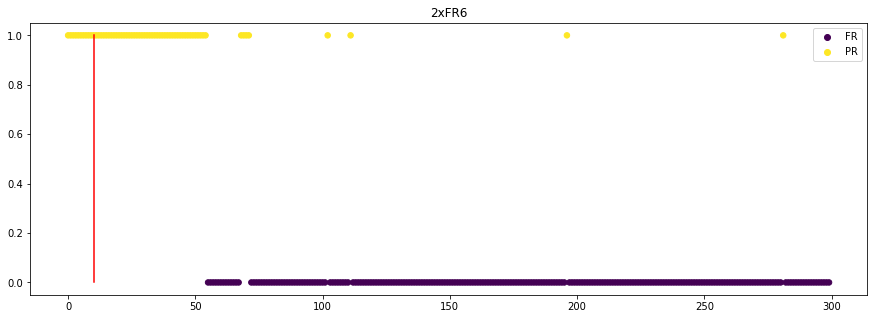

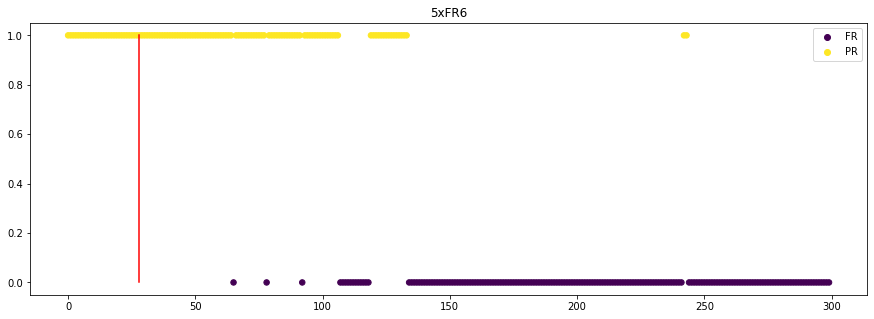

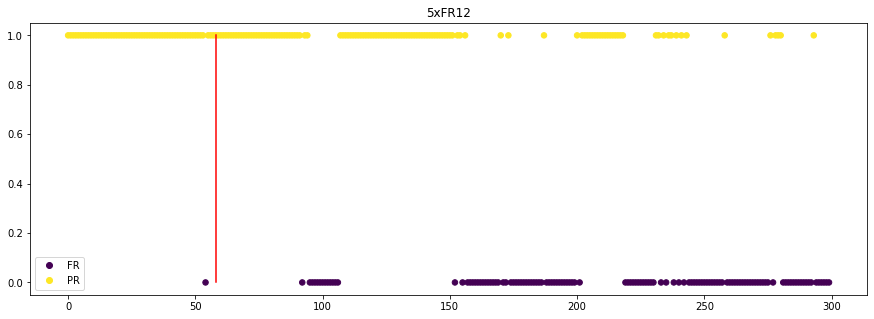

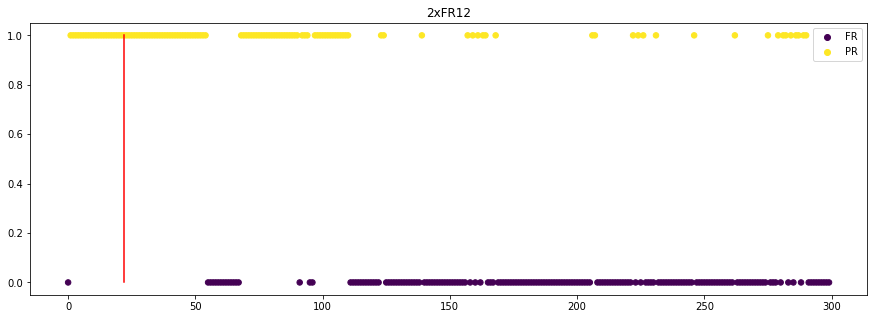

In [60]:
for (FR_limit, PR_reward), sessions in d.items():
    example_actions, example_rewards = sessions[np.random.randint(len(sessions))]
    example_actions = 1 - example_actions # to match the original paper's graphs
    plt.figure(figsize = (15, 5))
    scatter = plt.scatter(np.arange(len(example_actions)), example_actions, s = 30, c = example_actions)
    plt.legend(handles=scatter.legend_elements()[0], labels=['FR', 'PR'])
    plt.title('%dxFR%d'%(PR_reward, FR_limit))
    # add optimal line
    switch_time = optimal_switch[(FR_limit, PR_reward)]
    plt.plot([switch_time, switch_time], [0, 1], color='red')